In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from astropy.time import Time
from scipy.signal import convolve
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates import AltAz
from astropy.coordinates import ICRS
from scipy.optimize import curve_fit
from scipy.ndimage.filters import uniform_filter1d
%matplotlib inline

In [2]:
#Load data
CasA_raw = np.fromfile('AST326_ARO_CasA_calibration.dat')

In [3]:
#Name variables accordint to lab manual
nf = CasA_raw[0].astype(np.int32) #The first number in the array, number of frequency channels
nt = CasA_raw[1].astype(np.int32) #The second number in the array, number of time slices
ns = CasA_raw[2].astype(np.int32) #The third number in the array, size of each time slice
lf = CasA_raw[3:1027] #The fourth number to the length of nf, list of frequencies
lf_flipped = np.flip(lf,axis=0) #Frequencies are in reverse order so flip

In [4]:
#Real data begins after number 1027, all of the rest is header
CasA_data = CasA_raw[1027:]

#Slice the data into the time slices
CasA_slices = CasA_data.reshape(-1, 1027)
timestamp_CasA = CasA_slices[:,0] #In MJD
alt_CasA_ARO = CasA_slices[:,1] #altitude pointing of ARO
az_CasA_ARO = CasA_slices[:,2] #azimuth pointing of ARO
StokesI_CasA_data = CasA_slices[:, 3:1027] #Stokes I samples for each frequency, in order
StokesI_CasA_ARO = np.flip(StokesI_CasA_data, axis=1)

In [5]:
#Convert from AltAz to RADec
ARO_pos = EarthLocation(lat = '45d57m19.8s', lon = '281d55m37s', height = (260.4*u.m))
times = Time(timestamp_CasA, format = 'mjd') #Puts time into correct format
radec_coord = []
for n in range(len(times)):
    current_orient = SkyCoord(alt = alt_CasA_ARO[n]*u.deg, az = az_CasA_ARO[n]*u.deg, frame = 'altaz', obstime = times[n], location = ARO_pos)
    current_orient_radec = current_orient.transform_to('icrs')
    radec_coord.append(current_orient_radec)

In [6]:
#AltAz coordinates
AltAz_CasA_ARO = np.stack((alt_CasA_ARO, az_CasA_ARO), axis=-1)

<SkyCoord (ICRS): (ra, dec) in deg
    (350.85833333, 58.8)>


Text(0.5,0,'Coordinate Offset (Degrees)')

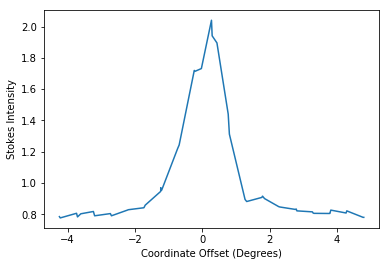

In [7]:
#Plot intensity for each frequency band
Stokes_1 = StokesI_CasA_ARO[:,0]
Stokes_mean1 = np.mean(Stokes_1)
Stokes_sigma1 = np.std(Stokes_1)

CasA = SkyCoord(ra='23h23m26s', dec = '58°48′')
#The Above converts to (ra, dec) in deg (350.85833333, 58.8)>
print(CasA)
offset_list = []
for n in range(len(radec_coord)):
    offset = CasA.separation(radec_coord[n])
    offset_list.append(offset.value)

#Change to not absolute value
offset_neg = np.negative(offset_list[0:22]).tolist()
offset_list_final = offset_list[22:]
for i in range(len(offset_neg)):
    offset_list_final.append(offset_neg[i])
    
offset_sorted = np.sort(offset_list_final)
offset_array = np.array(offset_sorted)

plt.plot(offset_array, Stokes_1)
plt.ylabel('Stokes Intensity')
plt.xlabel('Coordinate Offset (Degrees)')

Text(0,0.5,'Power in Sub-band (arb units)')

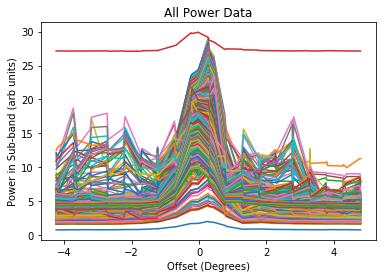

In [8]:
plt.plot(offset_array, StokesI_CasA_ARO)
plt.title('All Power Data')
plt.xlabel('Offset (Degrees)')
plt.ylabel('Power in Sub-band (arb units)')

Text(0,0.5,'Off-Source Power')

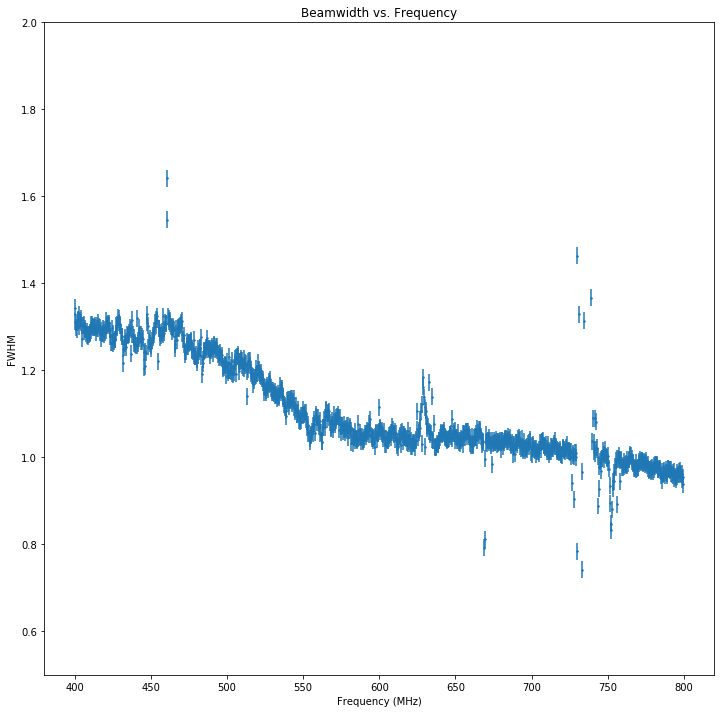

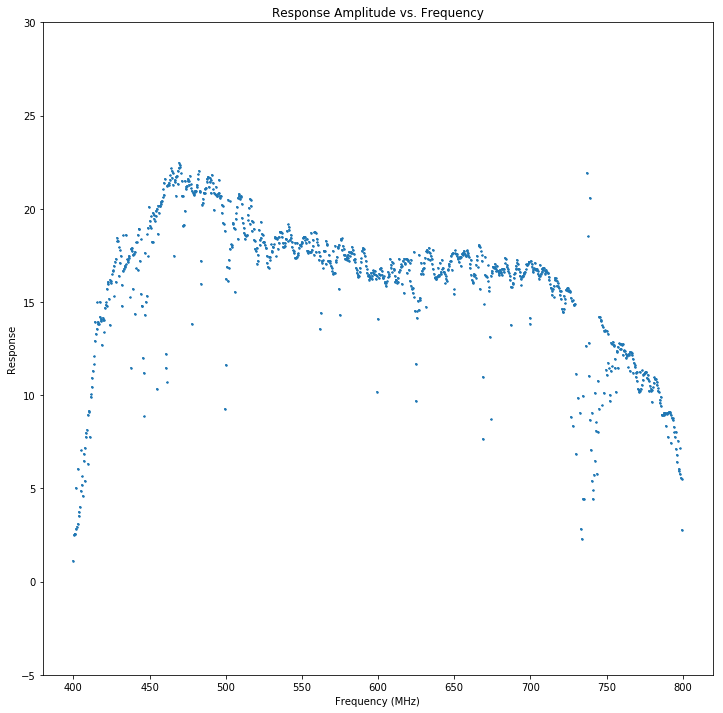

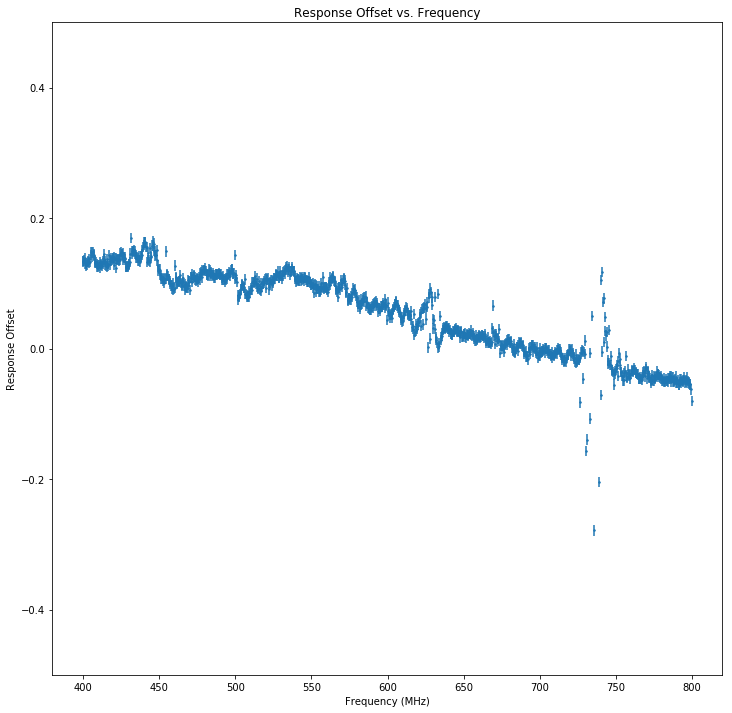

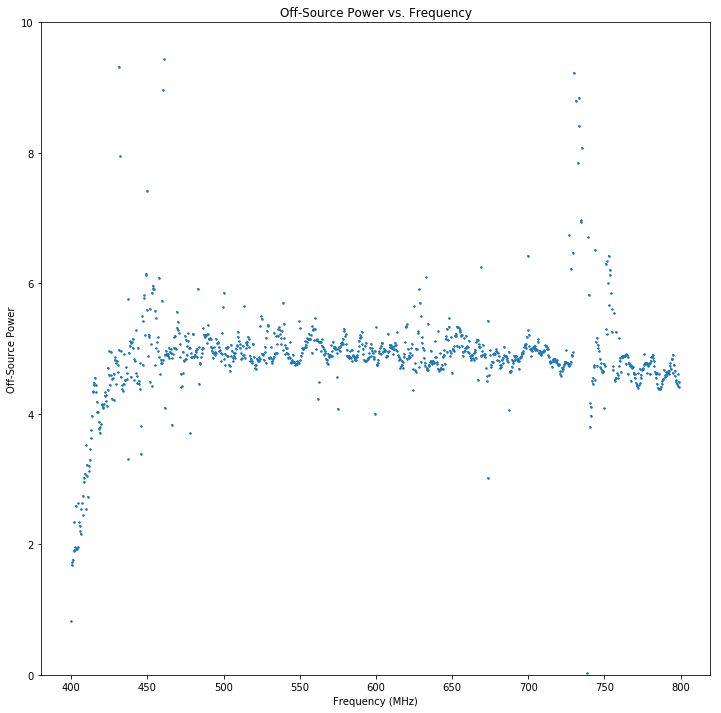

In [9]:
#Gaussian function
def Gaussian(x,*p):
    A, mu, sigma, base = p
    return A*np.exp(-(x-mu)**2/(2*sigma**2))+base

p0 = [20,0,1,5]
amplitude_array = np.zeros(nf)
sigma_array = np.zeros(nf)
mean_array = np.zeros(nf)
base_array = np.zeros(nf)
for i in range(0,1024):
    p_opt_all, p_cov_all = curve_fit(Gaussian, offset_array, StokesI_CasA_ARO[:,i], p0=p0) 
    amplitude_array[i] = p_opt_all[0]
    mean_array[i] = p_opt_all[1]
    sigma_array[i] = p_opt_all[2]
    base_array[i] = p_opt_all[3]

amplitude_err = np.sqrt(p_cov_all[0][0])
mean_err = np.sqrt(p_cov_all[1][1])
bw_err = 2.355*np.sqrt(p_cov_all[2][2])
base_err = np.sqrt(p_cov_all[1][1])

freq_axis = np.arange(400,800,(400/1024))

FWHM_exp = 2.355*sigma_array
plt.figure(figsize=(12,12))
plt.errorbar(freq_axis, FWHM_exp, xerr=None, yerr=bw_err, ls='',marker='o',markersize=1.5)
plt.ylim(0.5,2)
plt.title('Beamwidth vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('FWHM')
#plt.savefig('FWHM.png')

plt.figure(figsize=(12,12))
plt.errorbar(freq_axis, amplitude_array, xerr=None, yerr=amplitude_err, ls='', marker='o', markersize=1.5)
plt.ylim(-5,30)
plt.title('Response Amplitude vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Response')

plt.figure(figsize=(12,12))
plt.errorbar(freq_axis, mean_array, xerr=None, yerr=mean_err, ls='', marker='o', markersize=1.5)
plt.ylim(-0.5,0.5)
plt.title('Response Offset vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Response Offset')

plt.figure(figsize=(12,12))
plt.errorbar(freq_axis, base_array, xerr=None, yerr=base_err, ls='', marker='o', markersize=1.5)
plt.ylim(0,10)
plt.title('Off-Source Power vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Off-Source Power')

Text(0.5,1,'Theoretical Beamwidth Curve')

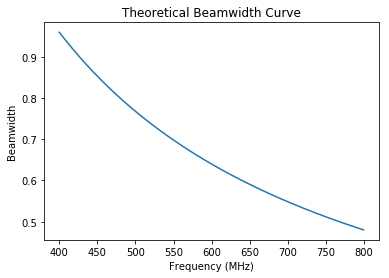

In [10]:
#Theoretical beamwidth
c = 3*(10**8) #speed of light
wavelength = np.zeros(len(lf_flipped))
for i in range(0, len(lf_flipped)):
    wavelength[i] = c/lf_flipped[i]
FWHM_theory = np.zeros(len(lf_flipped))
for i in range(0, len(wavelength)):
    FWHM_theory[i] = (1.028*wavelength[i]/46)*(180/np.pi) #convert from rad to degrees


freq_axis = np.arange(400,800,(400/1024))

plt.plot(freq_axis, FWHM_theory)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Beamwidth')
plt.title('Theoretical Beamwidth Curve')
#plt.savefig('theory_beam.png')

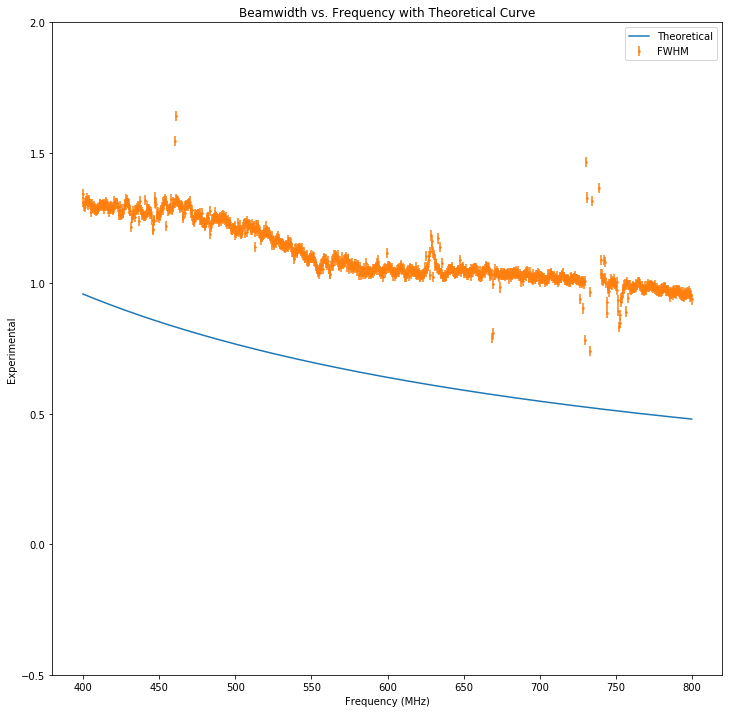

In [11]:
#Plot beamwidth against theoretical curve
plt.figure(figsize=(12,12))
plt.plot(freq_axis, FWHM_theory, label='Theoretical')
plt.errorbar(freq_axis, FWHM_exp, xerr=None, yerr=bw_err, ls='',marker='o',markersize=1.5, label='FWHM')
plt.ylim(-0.5,2)
plt.title('Beamwidth vs. Frequency with Theoretical Curve')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Experimental')
plt.legend()
#plt.savefig('FWHM_theory.png')

(-0.1, 2)

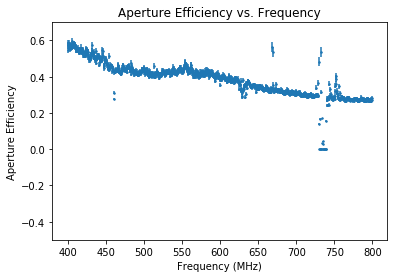

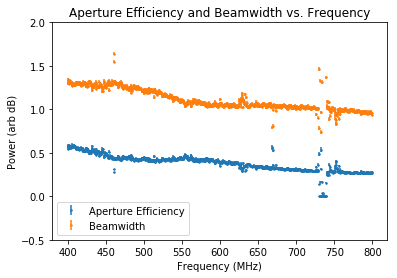

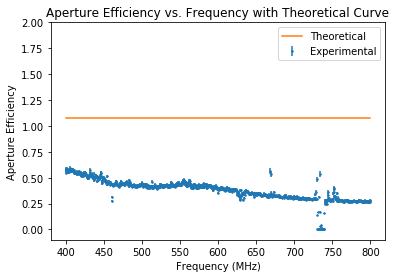

In [12]:
##Calculate aperture efficiency:
#Calculate solid angle
Omega = np.pi*(FWHM_exp*(np.pi/180))**2/(4*np.log(2))
Omega_err = ((np.pi*2*FWHM_exp*bw_err)*(np.pi/180)**2)/(4*np.log(2))

#Calculate collecting area 
Ae = wavelength**2/Omega 
Ae_err = (wavelength**2)*(Omega_err/(Omega**2))

#Calculate geometric area of the telescope
A_geom = np.pi*(22.9**2)

#Calculate aperture efficiency
eta = Ae/A_geom
eta_err = Ae_err/A_geom

#Plot aperture efficiency
plt.figure()
plt.errorbar(freq_axis, eta, xerr=None, yerr=eta_err, ls='', marker='o', markersize=1.5)
plt.title('Aperture Efficiency vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Aperture Efficiency')
plt.ylim(-0.5,0.7)
#plt.savefig('aperture_efficiency.pdf')

#Plot aperture efficiency and beamwidth
plt.figure()
plt.errorbar(freq_axis, eta, xerr=None, yerr=eta_err, ls='', marker='o', markersize=1.5, label='Aperture Efficiency')
plt.errorbar(freq_axis, FWHM_exp, xerr=None, yerr=bw_err, ls='', marker='o', markersize=1.5, label='Beamwidth')
plt.legend()
plt.ylim(-0.5,2)
plt.title('Aperture Efficiency and Beamwidth vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (arb dB)')

#Calculate theoretical aperture efficiency
Omega_theory = np.pi*(np.radians(FWHM_theory))**2/(4*np.log(2))
Ae_theory = wavelength**2/Omega_theory
eta_theory = Ae_theory/A_geom

#Plot aperture efficiency and theoretical aperture efficiency
plt.figure()
plt.errorbar(freq_axis, eta, xerr=None, yerr=eta_err, ls='', marker='o', markersize=1.5, label='Experimental')
plt.plot(freq_axis, eta_theory, label='Theoretical')
plt.legend()
plt.title('Aperture Efficiency vs. Frequency with Theoretical Curve')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Aperture Efficiency')
plt.ylim(-0.1,2)

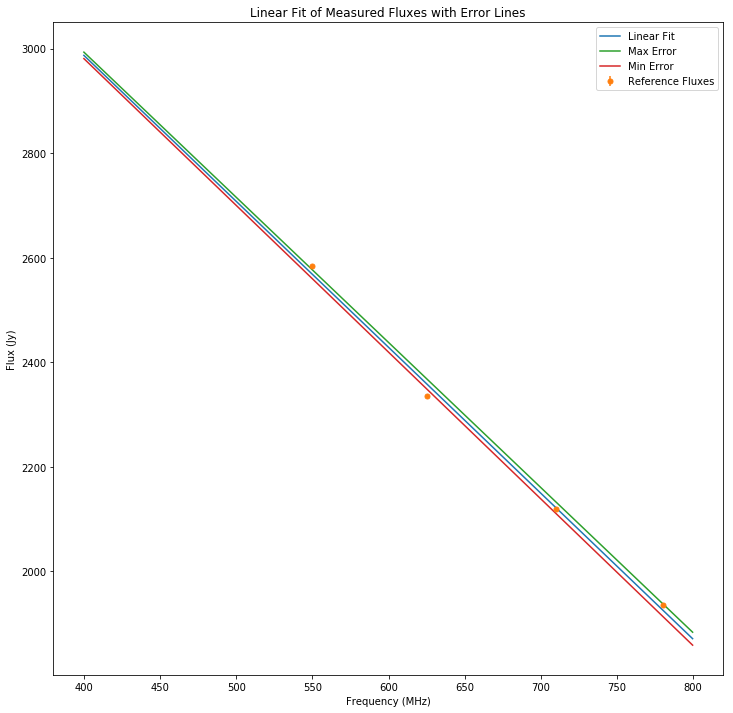

In [13]:
#Fluxes according to paper cited in lab manual: 
#550MHz = 5170Jy
#625MHz = 4670Jy
#710MHz = 4240Jy
#780MHz = 3870Jy
#Fluxes have dimmed roughly 50% in the last 40 years:
measured_freqs_Hz = np.array((550, 625, 710, 780))/1000000 
measured_freqs_MHz = np.array((550, 625, 710, 780))
measured_flux_1977_SI = np.array((5170, 4670, 4240, 3870))*10e-26 #Reference fluxes, convert from Jy to W/m^2Hz
measured_flux_1977_Jy = np.array((5170, 4670, 4240, 3870)) #Reference fluxes
measured_flux_now_SI = measured_flux_1977_SI*.5 #Divide by 2 because has dimmed 50%
measured_flux_now_Jy = measured_flux_1977_Jy*.5 #Divide by 2 because has dimmed 50%

#Define linear model function
def linear(x,b,m):
    y= m*x + b
    return y

#Define x-axis data
x_freq_data = np.arange(400,800, 400/len(measured_flux_now_Jy))

#Linear fit for reference fluxes
p_opt, p_cov = curve_fit(linear, measured_freqs_MHz, measured_flux_now_Jy, p0=(1,0))
p_opt_flux = p_opt
p_cov_flux = p_cov

#Plot reference fluxes with fit
#Define array for estimated reference fluxes around ARO band
estimated_ref_flux = linear(np.arange(400,800, 400/1024),*p_opt_flux) 
#where I have extended x-axis to cover whole frequency band (400-800MHz)
plt.figure(figsize=(12,12))
plt.plot(np.arange(400,800,400/1024), estimated_ref_flux, label='Linear Fit')
plt.errorbar(measured_freqs_MHz, measured_flux_now_Jy, yerr = p_cov_flux[1][1], ls='', marker='o', markersize=5, label='Reference Fluxes')
plt.plot(np.arange(400,800,400/1024), linear(np.arange(400,800,400/1024), p_opt_flux[0], 
                                             (p_opt_flux[1]+p_cov_flux[1][1])), label='Max Error')
plt.plot(np.arange(400,800,400/1024), linear(np.arange(400,800,400/1024), p_opt_flux[0], 
                                             (p_opt_flux[1]-p_cov_flux[1][1])), label='Min Error')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.title('Linear Fit of Measured Fluxes with Error Lines')
plt.legend()

[1163.81507608]
[61.67337645]


/Applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0,0.5,'Temperature (K)')

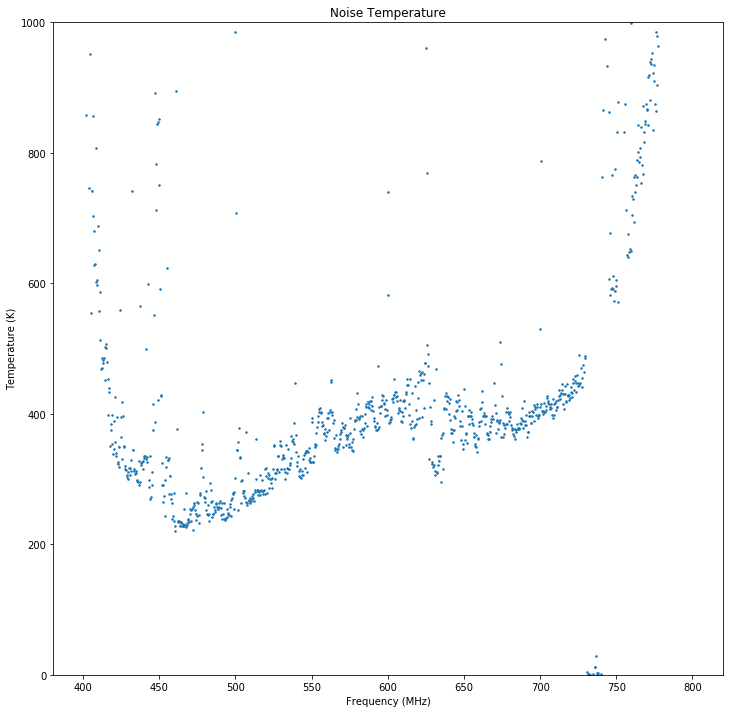

In [14]:
#Calculate the temperature corresponding to 625MHz:
wavelength_625 = 3e8/625e6
kB = 1.380648e-23

#Find the solid angle that corresponds to 625 MHz 
pos = np.where(lf[::-1] == 625e6)
Tangle = Omega[pos[0]]

#Define the effective aperture
Ae_625 = np.pi*(45.8/2)**2*eta[::-1][pos[0]]

#Now apply the equation to change temperature to the equation given to us in the lab manual
#This equation is rearranged using the known equation for power
T_625= measured_flux_now_Jy[1]*Ae_625/kB*1e-26
print(T_625)
T_625_err = measured_flux_now_Jy[1]*(T_625*(Ae_err[pos[0]]/Ae_625))/kB*1e-26
print(T_625_err)

#Define functions for initial conditions
#Function for gain
def p0(x,y,n):
    p0 = ((n*np.sum(x*y)) - (np.sum(x)*np.sum(y)))/((n*np.sum(x**2)) - ((np.sum(x))**2))
    return p0

#Function for system noise 
def p1(x,y,n,p):
    p1 = (1/n)*(np.sum(y) - p*np.sum(x))
    return p1

#Now calculating the temperature of CasA for all frequencies
A_all = np.pi*(45.8/2)**2*eta[::-1]
A_all_err = eta_err*np.pi*((48.5/2)**2)
T_all = estimated_ref_flux*A_all/kB*1e-26 
T_all_err = T_all*np.sqrt(((p_cov_flux[1][1]/estimated_ref_flux)**2 + (A_all_err/A_all/kB*1e-26)**2))
#Need to subract the power of the off source from the power of the source
powersource = StokesI_CasA_ARO[22]-StokesI_CasA_ARO[0]

p0_test = p0(T_all, powersource, 1024)
p1_test = p1(T_all, powersource,1024,p0_test)


#So now fit a line for every frequency
poptT = np.zeros((2,1024))
pcovT = np.zeros((2,2))
for i in np.arange(1024):    
    popT,covT, = curve_fit(linear, [10,T_all[::-1][i]], [StokesI_CasA_ARO[::][0,i], powersource[::][i]], p0 = (-0.009511083901105043,25.904513834402174))
    poptT[0,i] = popT[0]
    poptT[1,i] = popT[1]

plt.figure(figsize=(12,12))
plt.errorbar(lf_flipped/1e6, poptT[0]/poptT[1], xerr=None, yerr=T_all_err, ls ='', marker ='o', markersize=1.5)
plt.title('Noise Temperature')
plt.ylim(0,1000)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
#plt.savefig('noise_temp.png')

(0, 0.025)

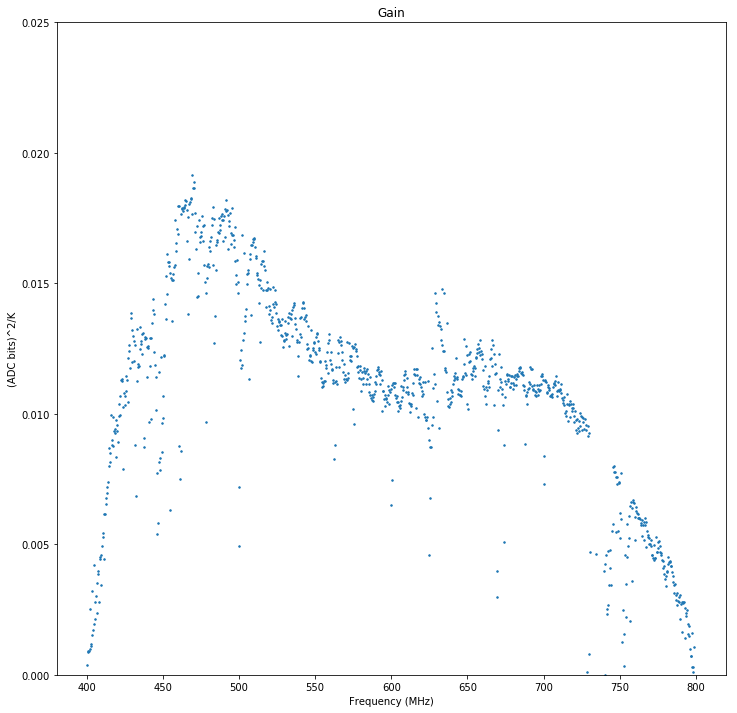

In [15]:
#Plot the gain
plt.figure(figsize=(12,12))
plt.errorbar(lf_flipped/1e6, poptT[1], ls='', marker='o', markersize=1.5)
plt.title('Gain')
plt.xlabel('Frequency (MHz)')
plt.ylabel('(ADC bits)^2/K')
plt.ylim(0,0.025)

In [16]:
#Pulsar header
pulsar_data = open("AST326_ARO_B0329+54.dat", "rb")
header_packed = pulsar_data.read(48)
header_unpacked = struct.unpack('=iiiidiiiId', header_packed)

slice_length = header_unpacked[0]
header_length = header_unpacked[1]
number_samples = header_unpacked[2]
data_type = header_unpacked[3]
cadence_raw = header_unpacked[4]
number_freqs = header_unpacked[5]
number_elems = header_unpacked[6]
spec_sum = header_unpacked[7]
handshake_index = header_unpacked[8]
handshake_utc = header_unpacked[9]

#Pulsar frequencies
header_info = pulsar_data.read(number_freqs*4*2)
freq_list = np.frombuffer(header_info[:number_freqs*4*2], dtype=np.float32)
freq_list = freq_list.reshape(-1,2)
freqs = freq_list.mean(axis=1)

data_list = np.zeros((119,1091,1024))
for i in np.arange(119):
    data_chunk = np.zeros((1091,1024))
    for i in np.arange(1091):
        data_header = np.frombuffer(pulsar_data.read(header_length), dtype=np.float32)
        index, az, alt = struct.unpack('Iff', data_header)
        data = np.frombuffer(pulsar_data.read(slice_length-header_length),dtype=np.float32)
        data_chunk[i] = data
    data_list[:i] = data_chunk

avgs = np.mean(data_list, axis=0)

timestep = cadence_raw*spec_sum
t = timestep*np.arange(avgs.shape[0]) 

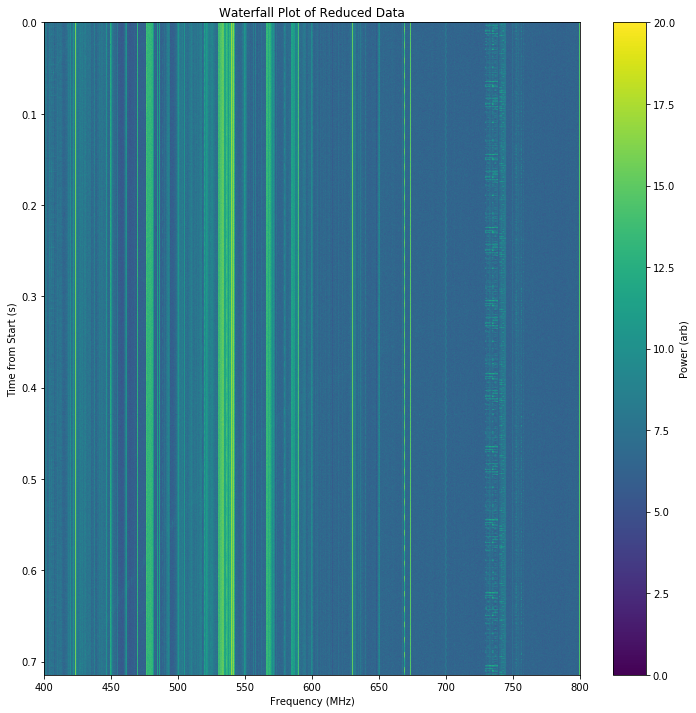

In [17]:
#Waterfall plot of averages
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(avgs),aspect="auto", extent=[400,800,np.amax(t), np.amin(t)], vmax=20, vmin=0)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of Reduced Data')
plt.colorbar().set_label('Power (arb)', rotation=90)

[[  19907.73236104   11808.23872915   10832.37005472 ... -101111.21192067
   -65796.40310562   -3152.42818845]
 [  19508.34884146   12457.75681106   11769.81684093 ...  -89773.52215622
   -64965.35097581   -3168.49210147]
 [  20007.57824094   12292.12970017   10898.2107989  ...  -97358.88043279
   -67716.4200952    -3164.13189651]
 ...
 [  19300.97662936   12327.85319467   12519.1472152  ...  -90701.51811559
   -67945.67585515   -3175.37663562]
 [  21136.60472901   11886.18089897   11838.79285865 ...  -92154.03353025
   -63016.67701623   -3193.27642442]
 [  19462.26612766   11986.85620167   10440.46086316 ...  -98771.04819705
   -64908.03703582   -3164.36138098]]
[ 17711.12300331  11369.81402386  10521.97797501 ... -90298.04161151
 -70094.94860469  -3172.39333749]


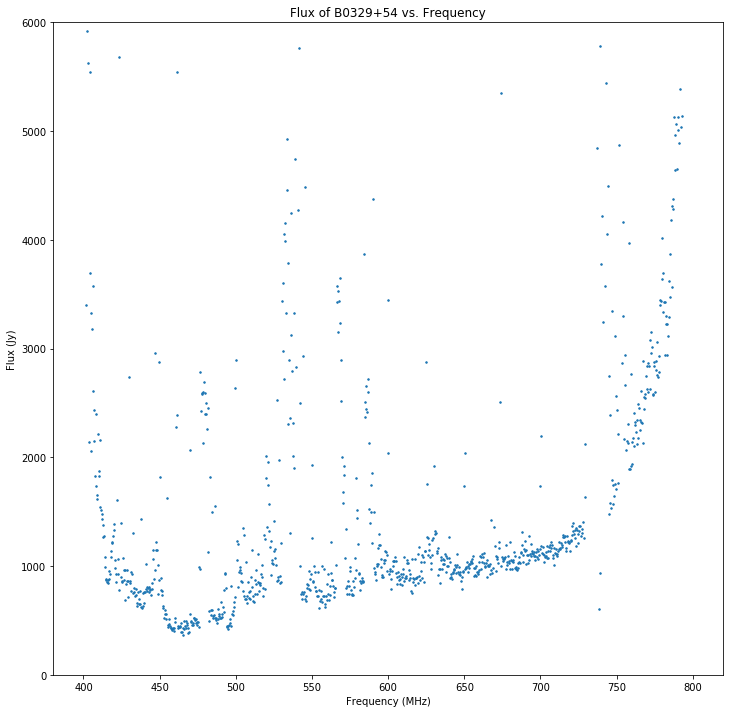

In [18]:
#Calculate flux of pulsar in Jy using gain from Cas A
power_by_gain = avgs/poptT[1] #Dividing Stokes I data by the gain to put it into Kelvin

#Convert to flux in SI units
pulsar_flux_SI = (power_by_gain*kB)/Ae

#Convert to flux in Jy
pulsar_flux_Jy = pulsar_flux_SI*1e26
print(pulsar_flux_Jy)

#Choose a band - avgs so should all be pretty similar
print(pulsar_flux_Jy[545])

#Plot representative flux
plt.figure(figsize=(12,12))
plt.plot(freqs, pulsar_flux_Jy[545],ls='', marker='o', markersize=1.5)
plt.title('Flux of B0329+54 vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.ylim(0,6000)
plt.savefig('pulsar_flux_avg.pdf')

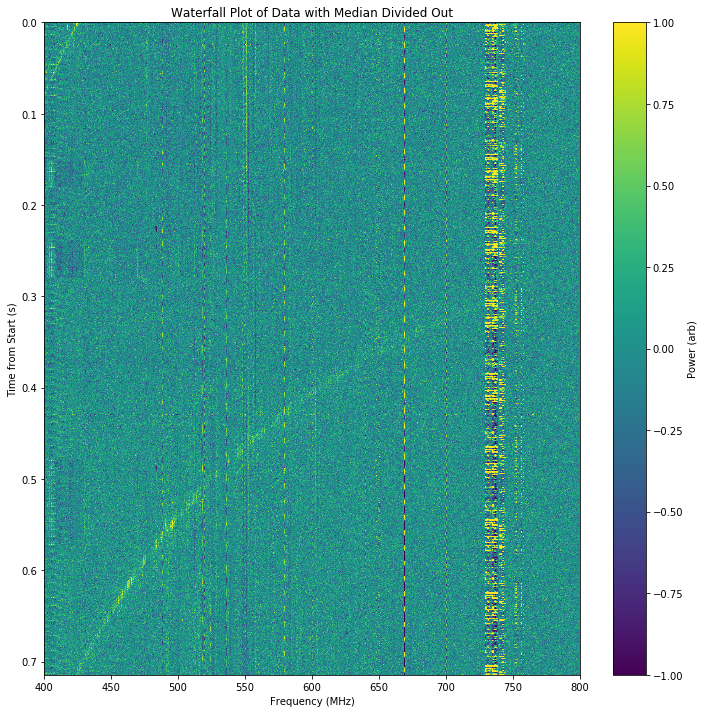

In [19]:
#Divide out median to reduce noise
median_RFI = np.median(avgs, axis=0)

RFI_less = avgs/median_RFI
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(RFI_less), extent=[400,800,np.amax(t), np.amin(t)], aspect='auto', vmax=1, vmin=-1)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of Data with Median Divided Out')
plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('waterfall_clean.png')

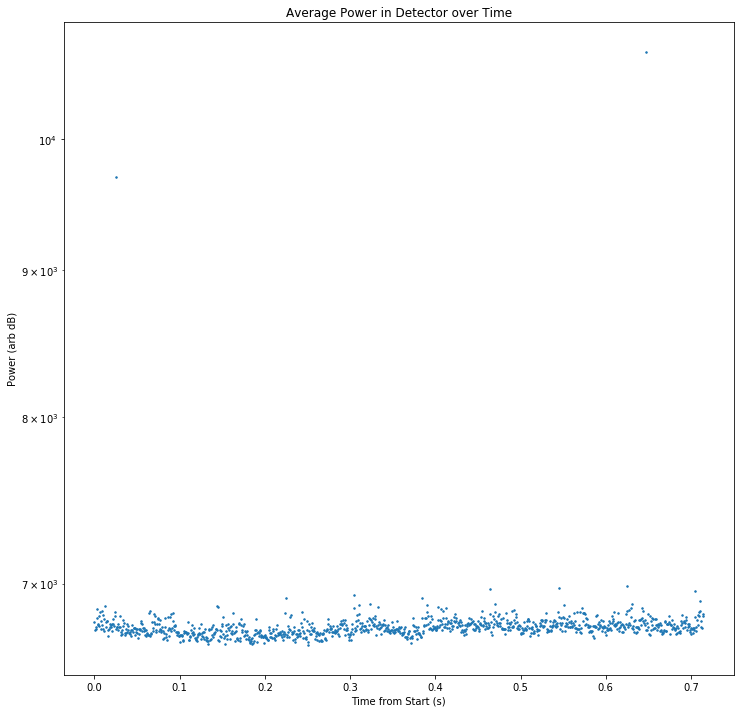

In [20]:
#Get rid of RFI
avgs_sum = np.sum(avgs, axis=1) #Sum over the frequencies
plt.figure(figsize=(12,12))
plt.plot(t, avgs_sum, ls='', marker = 'o', markersize = 1.5)
plt.semilogy()
plt.xlabel('Time from Start (s)')
plt.ylabel('Power (arb dB)')
plt.title('Average Power in Detector over Time')

large_values = np.where(avgs_sum > 8000)
period = 0.714519699726 #period
sample_period = period/timestep #how many samples in a period, dt is time per sample 
number_pulses_exp = int(10000/sample_period) #how many pulses you expect to have (can count 
#these in plot, should be about 9)

RFI_noise = large_values[0].tolist()
RFI_noise.append([0])
for i in np.arange(avgs.shape[0]):
    if i == RFI_noise[0]:
        RFI_noise.pop(0)
        continue

Text(0,0.5,'Flux Relative to Background')

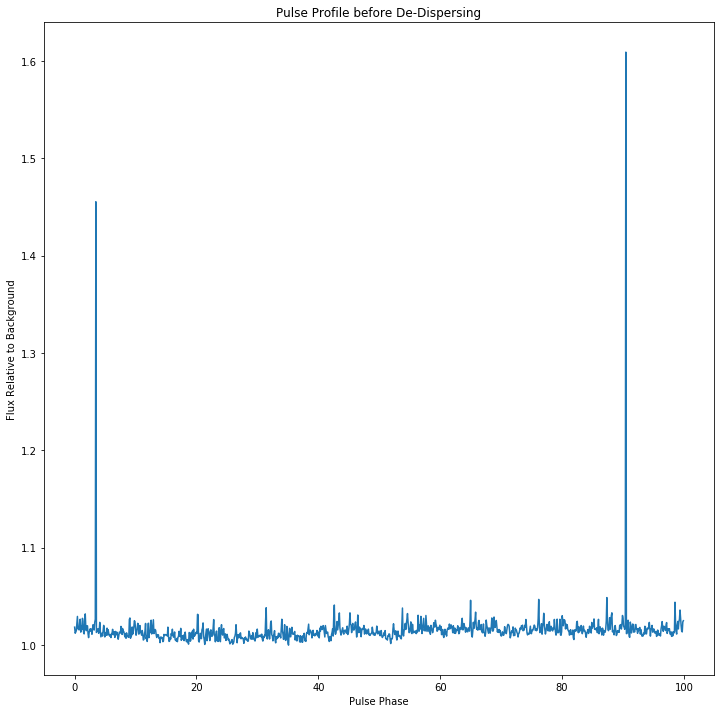

In [21]:
#Plot profile before de-dispersing
profile_dispersed = np.sum(avgs, axis=1)

#Normalize
normal_profile_dispersed = profile_dispersed/np.min(profile_dispersed)
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/1091),normal_profile_dispersed)
plt.title('Pulse Profile before De-Dispersing')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
#plt.savefig('pulse_profile.pdf')

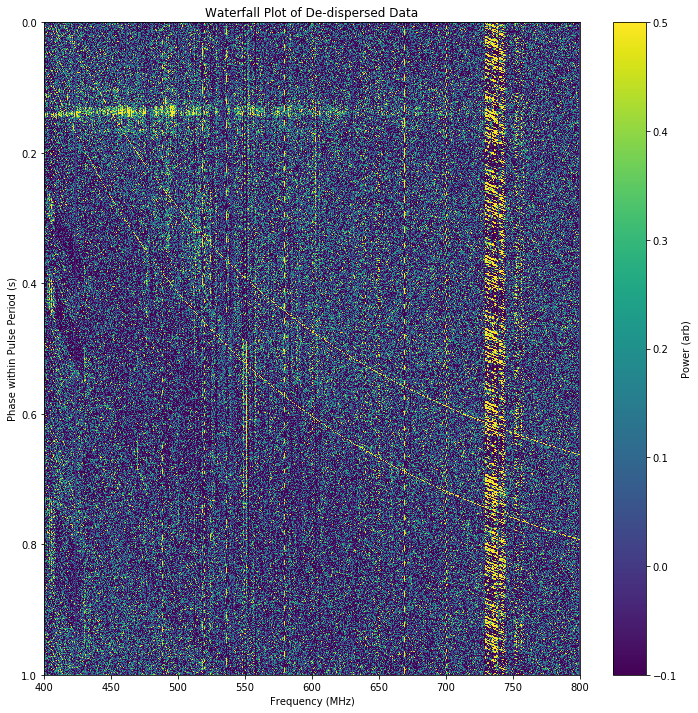

In [22]:
#De-disperse
freq_number=1024
k = 4.15e-3 #DM time prefactor
dm = 26.7641 #Looked up on ATNF - need to put into SI units? (It looks okay so I guess not?)
dispersion = (k*dm*(freqs/1000)**-2) 
dm_array = np.zeros((1091,1024))
for i in np.arange(freq_number):
    dm_array[:,i] = np.roll(avgs[:,i], -int(dispersion[i]/period*1091))
    
dedispersed_data = dm_array/np.median(dm_array, axis=0)

plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_data), extent = [np.amin(freqs), np.amax(freqs), 1, 0], aspect = 'auto', vmin = -.1, vmax = .5)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('waterfall_de_dispersed.pdf')

Text(0,0.5,'Flux Relative to Background')

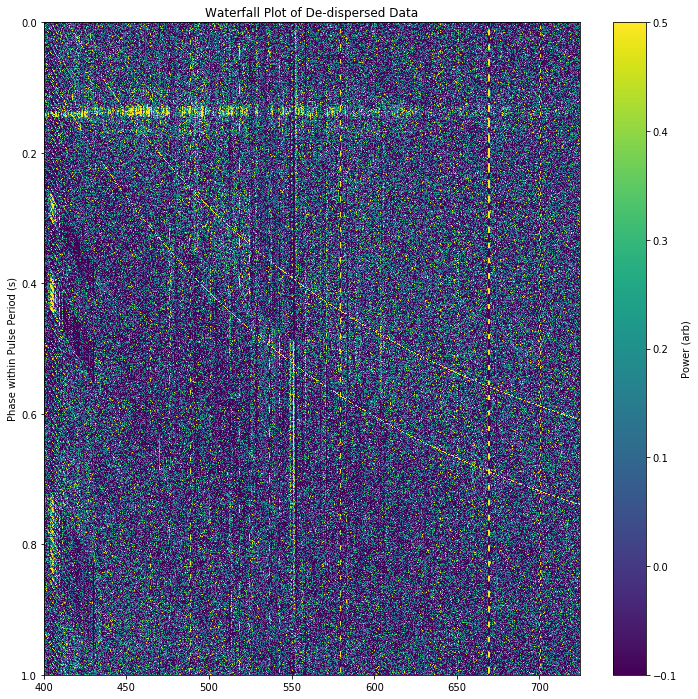

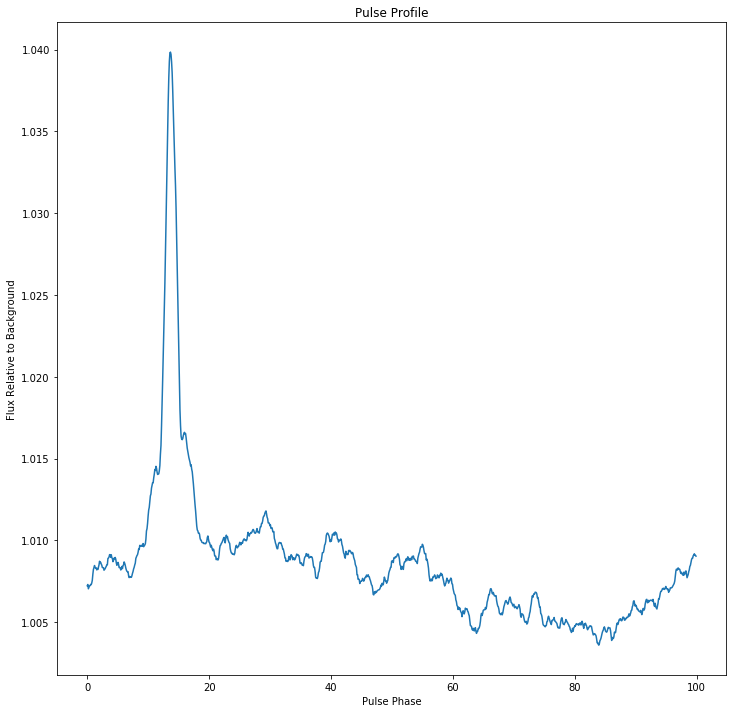

In [23]:
LTE_less = []
temp_list = []
for i in np.arange(0,1091):
    temp_list = list(dedispersed_data[i][0:830])
    LTE_less.extend(temp_list)

LTE_less_array = np.array(LTE_less)
LTE_reshaped = LTE_less_array.reshape(1091,830)
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(LTE_reshaped), extent = [np.amin(freqs), 724.41406, 1, 0], aspect = 'auto', vmin = -.1, vmax = .5)
plt.title('De-dispersed Data with LTE Band Excised')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('waterfall_dedispersed_noLTE.png')

profile = np.sum(LTE_reshaped, axis=1)

#Normalize
normal_profile = profile/np.min(profile)

#Smooth
smooth_profile = uniform_filter1d(normal_profile, 20)

plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/1091),smooth_profile)
plt.title('Pulse Profile')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background') 
#plt.savefig('smoothed_profile.png')

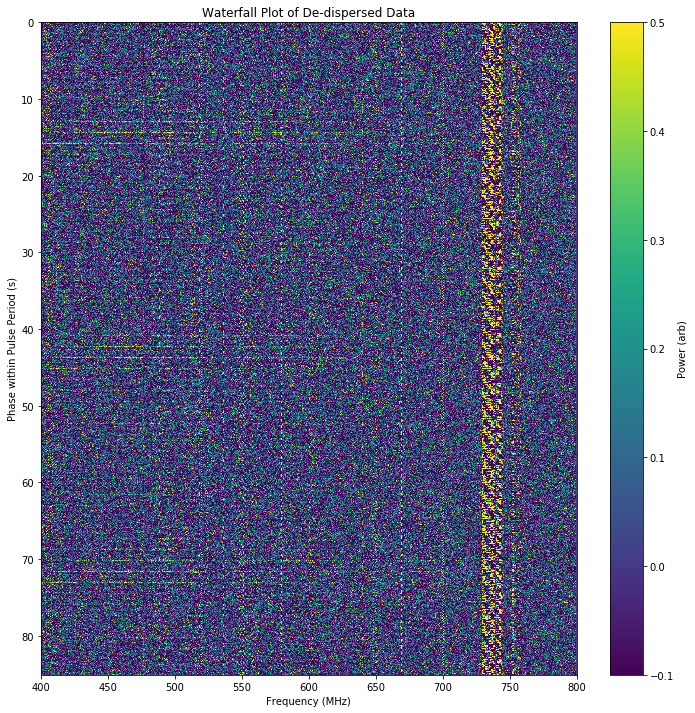

In [24]:
#De-disperse raw dataset
raw_dat = data_list.reshape(129829,1024) #Put data into one array
t_raw = timestep*np.arange(raw_dat.shape[0]) #Calculate new time axis (~80 seconds)
k = 4.15e-3 #DM time prefactor
dm = 26.7641 #Looked up on ATNF 
dispersion = (k*dm*(freqs/1000)**-2) 
dm_array = np.zeros((129829,1024))
for i in np.arange(freq_number):
    dm_array[:,i] = np.roll(raw_dat[:,i], -int(dispersion[i]/timestep)) #roll over the timestep
    
dedispersed_raw_data = dm_array/np.median(dm_array, axis=0)

plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_raw_data), extent = [np.amin(freqs), np.amax(freqs), np.amax(t_raw), np.amin(t_raw)], aspect = 'auto', vmin = -.1, vmax = .5)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('waterfall_de_dispersed.pdf')

In [ ]:
#Calculate flux of pulsar of raw data in Jy using gain from Cas A
power_by_gain_raw = raw_dat/poptT[1] #Dividing Stokes I data by the gain to put it into Kelvin

#Convert to flux in SI units
pulsar_flux_raw_SI = (power_by_gain_raw*kB)/Ae

#Convert to flux in Jy
pulsar_flux_raw_Jy = pulsar_flux_raw_SI*1e26
print(pulsar_flux_raw_Jy.shape)

#Choose a band - avgs so should all be pretty similar
print(pulsar_flux_raw_Jy[64914])

#Can also average over the frequencies
avg_flux_raw = np.mean(pulsar_flux_raw_Jy, axis=1)
print(avg_flux_raw)

In [26]:
#Remove LTE
LTE_less_raw = []
temp_list_raw = []
for i in np.arange(0,129829):
    temp_list_raw = list(dedispersed_raw_data[i][0:830])
    LTE_less_raw.extend(temp_list_raw)

LTE_raw_array = np.array(LTE_less_raw)
LTE_raw_reshaped = LTE_raw_array.reshape(-1,830)

#plt.figure(figsize=(12,12))
#plt.imshow(10*np.log10(LTE_raw_reshaped), extent = [np.amin(freqs), 724.41406, np.amax(t_raw), np.amin(t_raw)], aspect = 'auto', vmin = -.1, vmax = .5)
#plt.title('De-dispersed Raw Data with LTE Band Excised')
#plt.ylabel('Time from Start (s)')
#plt.title('Waterfall Plot of De-dispersed Data')
#plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('dedispersed_raw_noLTE.pdf')

In [29]:
#How pulse amplitudes vary in time
amplitude_data = np.sum(LTE_raw_reshaped, axis=1)
normal_amplitude = amplitude_data/np.min(amplitude_data)
#Convert to flux in Jy
#normal_amplitude_Jy = (((normal_amplitude/poptT[1][0:830])*kB)/Ae)*1e26

amplitude_median = np.median(LTE_raw_reshaped, axis=1)
#Convert to flux in Jy
#amplitude_median_Jy = (((amplitude_median/poptT[1][0:830])*kB)/Ae)*1e26
print(normal_amplitude.shape)
print(poptT[1].shape)

(129829,)
(1024,)


In [44]:
#Rebin timeseries data
flux_bins = 129829/1024 #Divide the period by the number of bins in the average pulse profile  #Create bins for the timeseries
print(flux_bins)
amplitude_reshaped_flux = normal_amplitude.reshape(1024,126) #Reshape the amplitude data accordingly
amplitude_rebinned = np.mean(amplitude_reshaped, axis=1) #Take the mean
print(amplitude_rebinned.shape)

126.7861328125


ValueError: cannot reshape array of size 129829 into shape (1024,126)

In [43]:


plt.figure(figsize=(12,12))
plt.plot(t_raw, normal_amplitude)
plt.title('Amplitude vs. Time')
plt.xlabel('Time since Start (s)')
plt.ylabel('Flux Relative to Background')
#plt.savefig('amplitude_time.pdf')
#plt.xlim(0,0.2)
#plt.ylim(1.025,1.06)

plt.figure(figsize=(12,12))
plt.plot(t_raw, amplitude_median) #This plot is less noisy
plt.title('Median of the Amplitudes vs. Time')
plt.xlabel('Time since Start (s)')
plt.ylabel('Flux Relative to Background')

ValueError: operands could not be broadcast together with shapes (129829,) (830,) 

In [35]:
#Find the peaks using Andy's telescope peak finding function: USE THE CENTROID FUNCTION
def centfindert(x, threshold,threshold2): #Choose thresholds
    pixels = np.arange(0,len(x))
    intensity = x
    peaksx = [] #This is the values that the peaks are centred around
    peaksy = []
    peak_dex = (list(intensity))
    inversep_dex=intensity[::-1]
    for i in range(len(intensity)-1):
        if intensity[i] > threshold and intensity[i-1] <intensity[i] and intensity[i+1] < intensity[i]:
            peaksx.append(pixels[i])
            peaksy.append(intensity[i])
    peaksx = np.array(peaksx)
    peaksy = np.array(peaksy)
    return peaksy

amplitude_peaks = centfindert(normal_amplitude, 1.03,1.03)
#print(amplitude_peaks)

plt.figure(figsize=(12,12))
plt.hist(amplitude_peaks_Jy)
plt.title('Pulse Amplitude Variation')
plt.xlabel('Flux (Jy)')
plt.ylabel('Number of Peaks per Flux Bin')
#plt.savefig('amplitude_hist.pdf')

amplitude_median_peaks = centfindert(amplitude_median, 1.02, 1.02)
#print(amplitude_median_peaks.shape) 

plt.figure(figsize=(12,12))
plt.hist(amplitude_median_peaks_Jy)
plt.title('Pulse Median Amplitude Variation')
plt.xlabel('Flux (Jy)')
plt.ylabel('Number of Peaks per Flux Bin')

ValueError: operands could not be broadcast together with shapes (595,) (1024,) 